# PA004 - HEALTH INSURANCE CROS-SELL

Last version of project, according Machine Learning Fundamentals course

## 0 - IMPORTS AND FUNCTIONS

In [1]:
import warnings
import optuna
import random
import pickle

import lightgbm                                               as lgbm
import scikitplot                                             as skplt
import matplotlib.patches                                     as mpatches
import matplotlib.pyplot                                      as plt
import numpy                                                  as np
import plotly.express                                         as px
import pandas                                                 as pd
import seaborn                                                as sns

from sklearn                 import preprocessing             as pp
from sklearn                 import model_selection           as ms
from sklearn                 import neighbors                 as nh
from sklearn                 import ensemble                  as en
from sklearn                 import metrics                   as mt

from pandas_profiling        import ProfileReport
from IPython.core.display    import HTML
from IPython.display         import Image
from xgboost                 import XGBClassifier
from sklearn.metrics         import log_loss
from sklearn.model_selection import StratifiedKFold
from optuna.integration      import LightGBMPruningCallback
from sklearn.metrics         import precision_recall_curve

warnings.filterwarnings( 'ignore' )

C:\Users\perot\anaconda3\envs\health_insurance_venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\perot\AppData\Local\Temp\ipykernel_21860\3899416516.py:21: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling        import ProfileReport


### 0.1 - HELPER FUNCTIONS

In [2]:
def recall_at_k (data, k=20000):
    # Reset Index
    data = data.reset_index( drop=True )

    # Create Ranking Order
    data['ranking'] = data.index + 1

    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    return data.loc[k, 'recall_at_k'] 

def precision_at_k (data, k=20000):
    # Reset Index
    data = data.reset_index( drop=True )

    # Create Ranking Order
    data['ranking'] = data.index + 1

    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    return data.loc[k, 'precision_at_k']

def cramer_v( x, y):
    cm = pd.crosstab( x, y).values   
    n = cm.sum()
    r, k = cm.shape    
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1) 
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def prediction_score(model, data):
    # Separating train and validation dataset for each kfold
    x_train = data.drop(columns=['response'])
    y_train = data['response']
    
    # prediction probability (score)
    yhat_proba = model.predict_proba(x_train)[:, 1].tolist()
    
    # merging score to dataset
    data_scored = data.copy()
    data_scored['score'] = yhat_proba
    
    # sort
    data_scored = data_scored.sort_values('score', ascending=False)
    
    # precision and recall
    data_scored = data_scored.reset_index(drop=True)
    data_scored['n_samples'] = data_scored.index + 1
    data_scored['precision_at_k'] = data_scored['response'].cumsum() / data_scored['n_samples']
    data_scored['recall_at_k'] = data_scored['response'].cumsum() / data_scored['response'].sum()
    
    return data_scored

def cross_validation(kfold, modelName, model, data, at_k):
    
    # Number of folds
    fold=ms.StratifiedKFold(n_splits = kfold, shuffle=True, random_state=42)
    
    # Performance variables
    precision_list = []
    recall_list = []
    cv_performance = {}
    
    for train_cv,val_cv in fold.split(data, data['response']):
        
        # Separating train and validation dataset for each kfold
        # training data
        x_train_fold = data.iloc[train_cv]
        x_train_fold = x_train_fold[cols_selected]
        
        y_train_fold = data['response'].iloc[train_cv]
        
        # validation data
        x_val_fold = data.iloc[val_cv]
        x_val_fold = x_val_fold[cols_selected]
        
        y_val_fold = data['response'].iloc[val_cv]
        
        # fitting the model
        model_fitted = model.fit(x_train_fold,y_train_fold)
        
        # getting the prediction probability
        x_val_fold['response'] = y_val_fold
        val_scored = prediction_score(model_fitted, x_val_fold)
        
        # Getting precision and recall at k
        precision = val_scored.loc[at_k, 'precision_at_k']
        recall = val_scored.loc[at_k, 'recall_at_k']
        
        precision_list.append(precision)
        recall_list.append(recall)
        
    # calculating the mean and std performance of all kfolds
    precision_cv = np.round(np.mean(precision_list),4).astype(float)
    std_precision_cv = '+/-' + np.round(np.std(precision_list),4).astype(str)
    recall_cv = np.round(np.mean(recall_list),4).astype(float)
    std_recall_cv = ' +/- ' + np.round(np.std(recall_list),4).astype(str)
        
    cv_performance[modelName] = [precision_cv, std_precision_cv, recall_cv, std_recall_cv]
    model_performance_cv = pd.DataFrame(cv_performance, index=['precision_at_k', 'std_precision', 'recall_at_k', 'std_recall'])

    return model_performance_cv

def ml_performance( model_name, precision_atK, recall_atK ):
    
    return pd.DataFrame( {'Model Name': model_name,
                          'Precision_at_K': precision_atK,
                          'Recall_at_K': recall_atK}, index=[0])

def data_preparation (df_prep):
    # Fitting vehicle_age column
    df_prep['vehicle_age'] = df_prep['vehicle_age'].apply(lambda x: 1 if (x == '< 1 Year') else 2 if (x == '1-2 Year') else 3)

    # Fitting vehicle_damage column
    df_prep['vehicle_damage'] = df_prep['vehicle_damage'].apply(lambda x: 1 if (x == 'Yes') else 0)
    
    # STANDARDIZATION

    # annual premium
    df_prep.loc[:, 'annual_premium'] = ss_ap.transform( df_prep[['annual_premium']].values )



    # REESCALING

    # age
    df_prep.loc[:, 'age'] = mms_age.transform( df_prep[['age']].values )

    # vintage
    df_prep.loc[:, 'vintage'] = mms_vintage.transform( df_prep[['vintage']].values )



    # ENCODER

    # policy sales channel
    df_prep.loc[:, 'policy_sales_channel'] = df_prep['policy_sales_channel'].map( fe_policy_sales_channel )

    # region code
    df_prep.loc[:, 'region_code'] = df_prep.loc[:, 'region_code'].map( fe_region_code )

    # gender
    df_prep.loc[:, 'gender'] = df_prep.loc[:, 'gender'].map( fe_gender )

    # FILL NAN VALUES
    df_prep = df_prep.fillna(0)
    
    # Feature Selection
    cols_selected = ['vintage', 'annual_premium','age','region_code','vehicle_damage','policy_sales_channel','previously_insured','vehicle_age']
    
    return( df_prep[cols_selected] )

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [12, 6]
    plt.rcParams['font.size'] = 24
    sns.set(font_scale=2)
    display( HTML( '<style>.container {width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

In [3]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 1 - DATA LOAD & DATA DESCRIPTIVE

In [4]:
# All data - Linux
#df = pd.read_csv('/home/reng/Documents/ds_repos/Projects/Health_Insurance_Cross_Sell/data/raw/data.csv')

# All Data - Windows
df_raw = pd.read_csv('C:/Users/perot/Documents/ds_repos/projects/Health_Insurance_Cross_Sell/data/raw/data.csv') 

### 1.1 - SPLIT DATASET INTO TRAINING, TEST AND VALIDATION

In [5]:
# Applying train test split to create Train, Validation and Test datasets

X = df_raw.drop( 'response', axis=1 )
y = df_raw['response'].copy()
x_train, x_valid, y_train, y_valid = ms.train_test_split( X, y, test_size=0.15 )
x_train, x_test, y_train, y_test = ms.train_test_split( x_train, y_train, test_size=0.15, shuffle=True, random_state=None )

print(f" x_train: {x_train.shape}\n y_train: {y_train.shape}\n x_valid: {x_valid.shape}\n y_valid: {y_valid.shape}\n x_test: {x_test.shape}\n y_test: {y_test.shape}\n")

 x_train: (275350, 11)
 y_train: (275350,)
 x_valid: (57167, 11)
 y_valid: (57167,)
 x_test: (48592, 11)
 y_test: (48592,)



### 1.2 - DATA DESCRIPTION

In [6]:
df1 = x_train.copy()

In [7]:
prof = ProfileReport(df1)
prof.to_file(output_file='data_descriptive.html')

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]


## 2 - FEATURE ENGINEERING

In [8]:
df2 = df1.copy()

In [9]:
# Fitting vehicle_age column
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 1 if (x == '< 1 Year') else 2 if (x == '1-2 Year') else 3)

# Fitting vehicle_damage column
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if (x == 'Yes') else 0)

## 3 - DATA FILTERING

In [10]:
df3 = df2.copy()

## 4 - EXPLORATORY DATA ANALYSIS (EDA)

In [11]:
df4 = df3.copy()

In [12]:
df4_eda = pd.concat([df4, y_train], axis=1)

### 4.1 - UNIVARIATE ANALYSIS

In [13]:
df4_eda.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
85017,297300,Male,66,43,124,1,2,0,1,2630,171,0
84710,294785,Female,37,50,26,1,2,0,0,27189,130,0
249089,84982,Female,70,28,122,1,2,1,0,44822,62,0
10258,82179,Female,63,19,26,1,2,1,0,25305,136,0
266875,227015,Female,28,36,160,1,1,0,1,32025,39,0


<AxesSubplot: xlabel='vintage', ylabel='Density'>

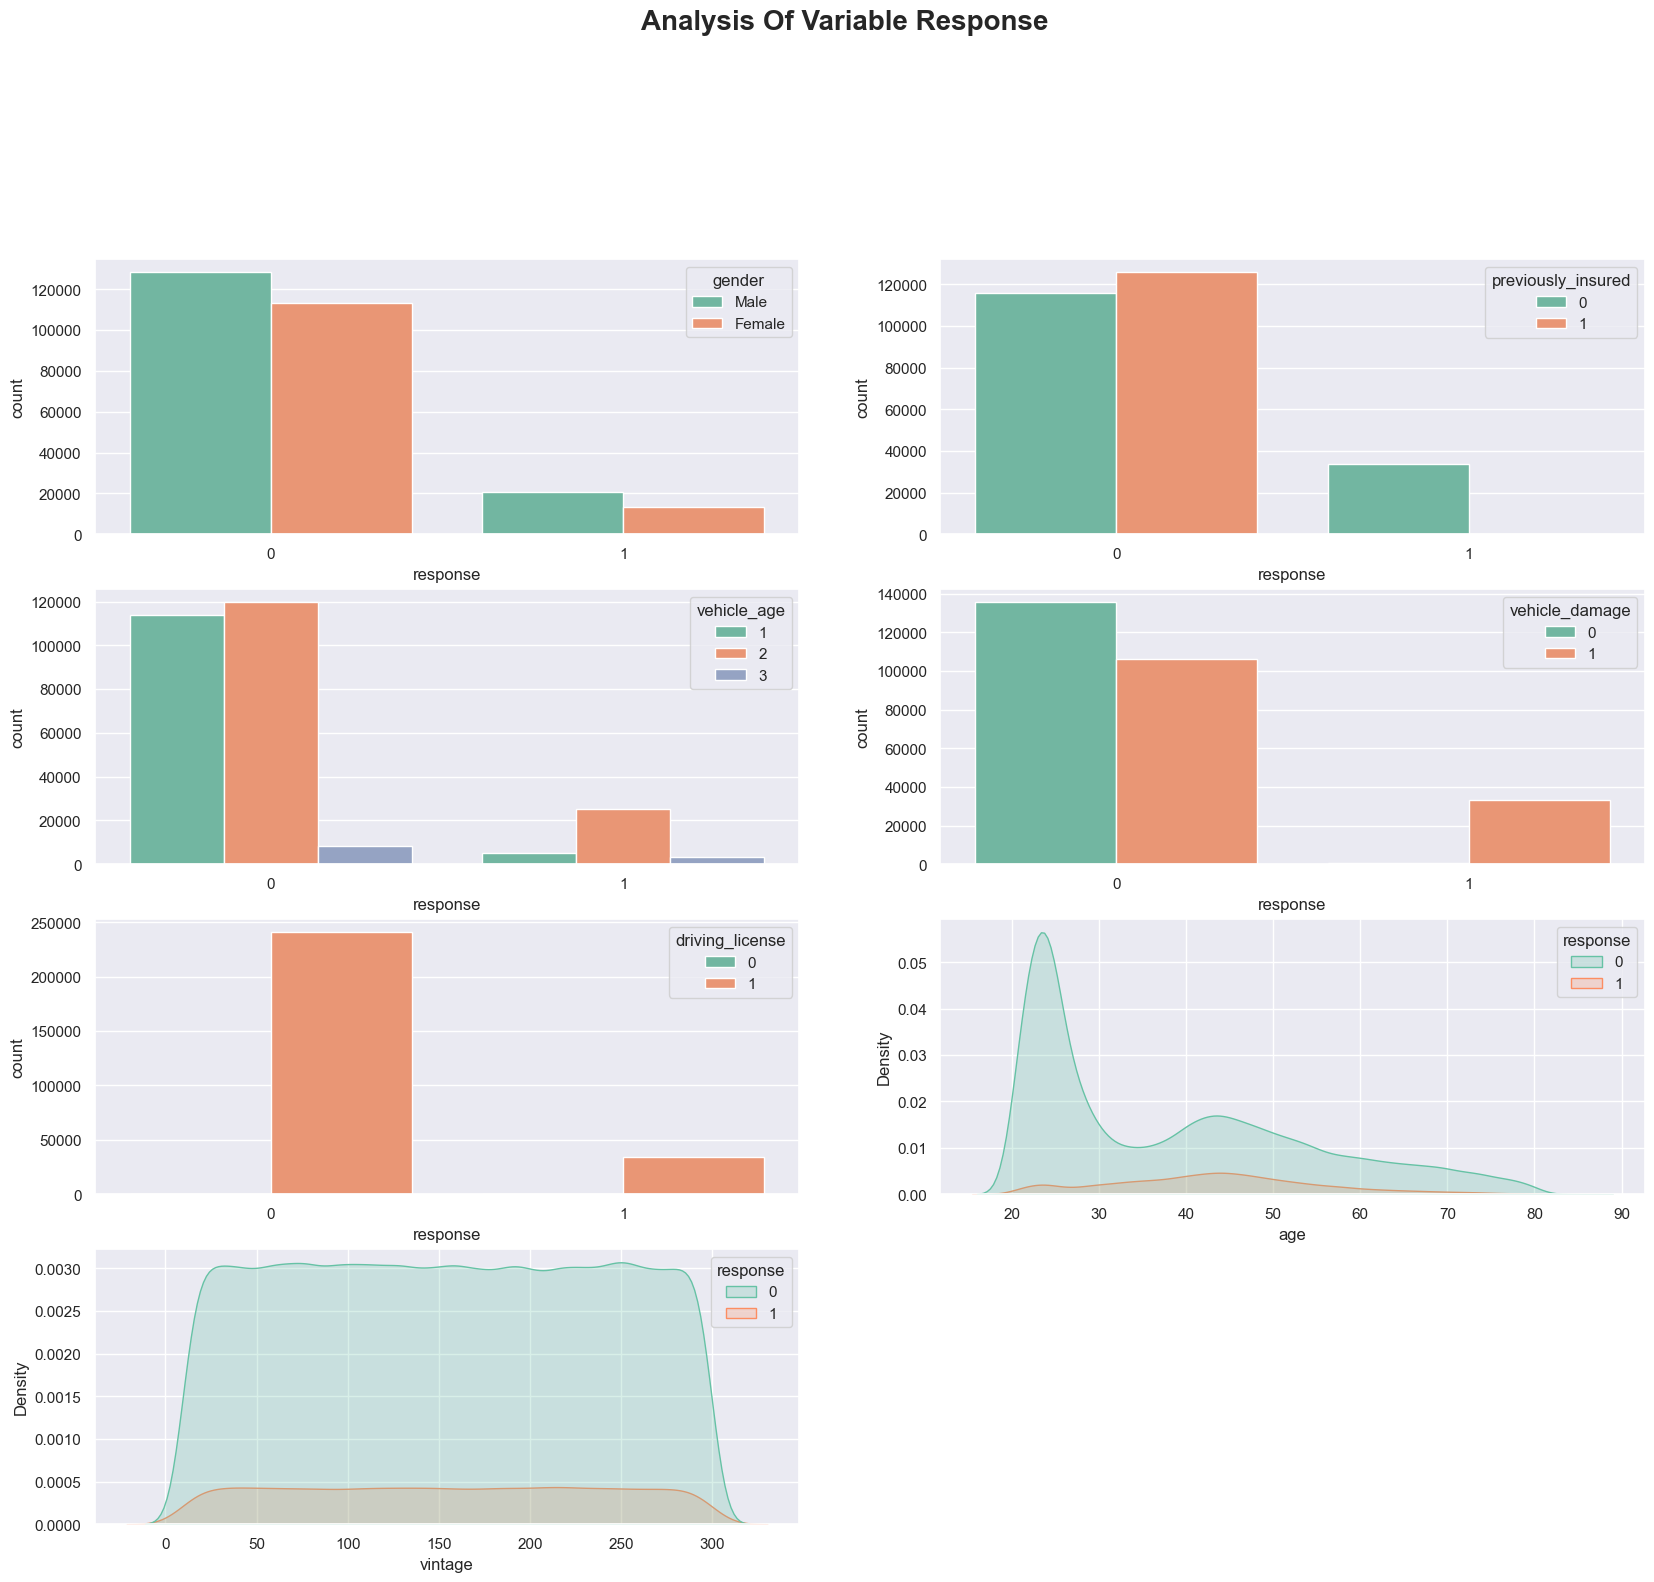

In [14]:
plt.figure(figsize = (20, 25))
plt.suptitle("Analysis Of Variable Response",fontweight="bold", fontsize=20)

plt.subplot(6,2,1)
sns.countplot(x = 'response', hue = 'gender', palette = 'Set2', data = df4_eda)

plt.subplot(6,2,2)
sns.countplot(x = 'response', hue = 'previously_insured', palette = 'Set2', data = df4_eda)

plt.subplot(6,2,3)
sns.countplot(x = 'response', hue = 'vehicle_age', palette = 'Set2', data = df4_eda)

plt.subplot(6,2,4)
sns.countplot(x = 'response', hue = 'vehicle_damage', palette = 'Set2', data = df4_eda)

plt.subplot(6,2,5)
sns.countplot(x = 'response', hue = 'driving_license', palette = 'Set2', data = df4_eda)

plt.subplot(6,2,6)
sns.kdeplot(x='age', hue='response', palette = 'Set2', shade=True, data=df4_eda)

plt.subplot(6,2,7)
sns.kdeplot(x='vintage', hue='response', palette = 'Set2', shade=True, data=df4_eda)

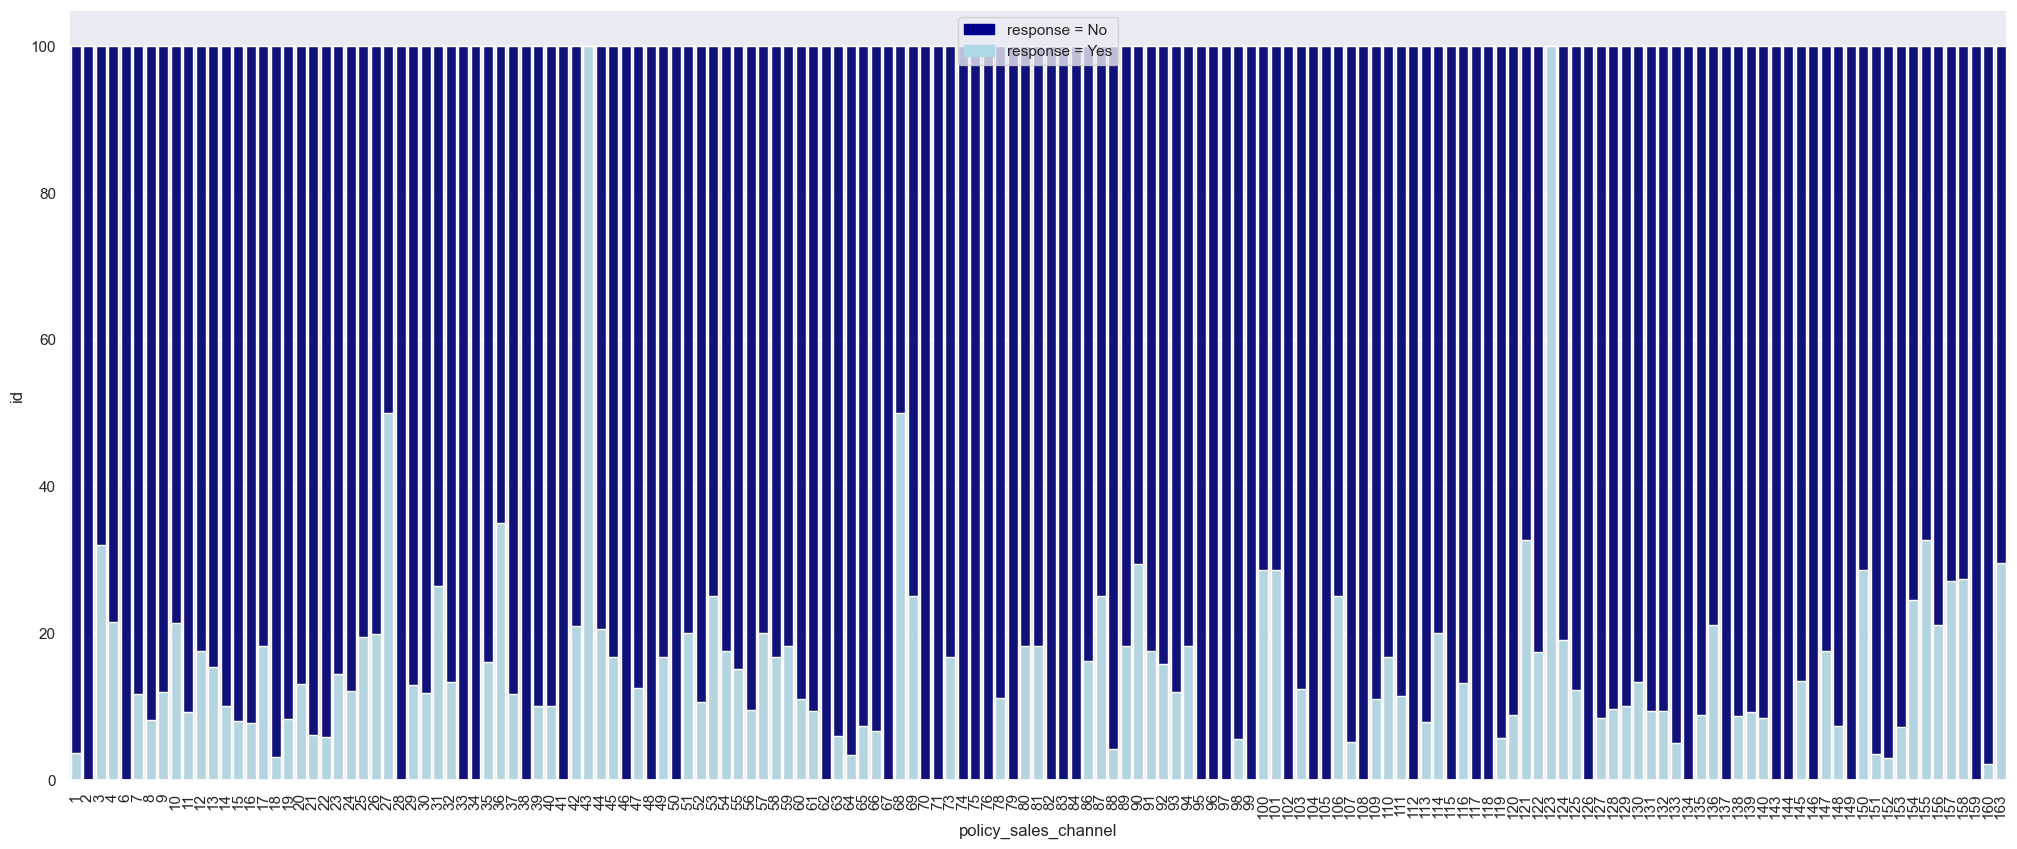

In [15]:
# 'policy_sales_channel'

# set the figure size
plt.figure(figsize=(25, 10))

# from raw value to percentage
total = df4_eda.groupby('policy_sales_channel')['id'].count().reset_index()
response_1 = df4_eda.loc[df4_eda.response == 1 ].groupby('policy_sales_channel')['id'].count().reset_index()
response_0 = df4_eda.loc[df4_eda.response == 0 ].groupby('policy_sales_channel')['response'].sum().reset_index()
resp = pd.merge(response_1, response_0, how = 'outer', on = 'policy_sales_channel')
resp['id'] = resp['id'].fillna(0)
resp = resp.sort_values(by='policy_sales_channel')
resp['id'] = [i / j * 100 for i,j in zip(resp['id'], total['id'])]
total['id'] = [i / j * 100 for i,j in zip(total['id'], total['id'])]

# bar chart 1 -> top bars (group of 'smoker=No')
bar1 = sns.barplot(x="policy_sales_channel",  y="id", data=total, color='darkblue')

# bar chart 2 -> bottom bars (group of 'smoker=Yes')
bar2 = sns.barplot(x="policy_sales_channel", y="id", data=resp, color='lightblue')

# add legend
plt.xticks(rotation=90)
top_bar = mpatches.Patch(color='darkblue', label='response = No')
bottom_bar = mpatches.Patch(color='lightblue', label='response = Yes')
plt.legend(handles=[top_bar, bottom_bar])

# show the graph
plt.show()

### 4.2 - BIVARIATE ANALYSIS

In [16]:
#1.The interest on purchase the vehicle insurance is greater for customers that damaged their vehicle before and doesn't have insurance. (FALSE)
d1 = df4_eda[( df4_eda['previously_insured'] == 0) & (df4_eda['vehicle_damage'] == 1)]

ax1 = d1[['response','id']].groupby('response').count().reset_index()
ax1['percentage'] = round(ax1['id'] / d1['id'].count()*100)
ax1

,response,id,percentage
0,0,99016,75.0
1,1,33046,25.0


In [17]:
# 2. The interest on purchase the vehicle insurance is greater for woman than men. (FALSE)
aux2 = pd.crosstab(df4_eda['gender'], df4_eda['response'])
aux2['percentage'] = aux2[1]/(aux2[0]+aux2[1])
aux2

response,0,1,percentage
gender,,,
Female,113224,13164,0.104155
Male,128314,20648,0.138613


Text(0.5, 1.0, 'Annual Premium: 30k or less')

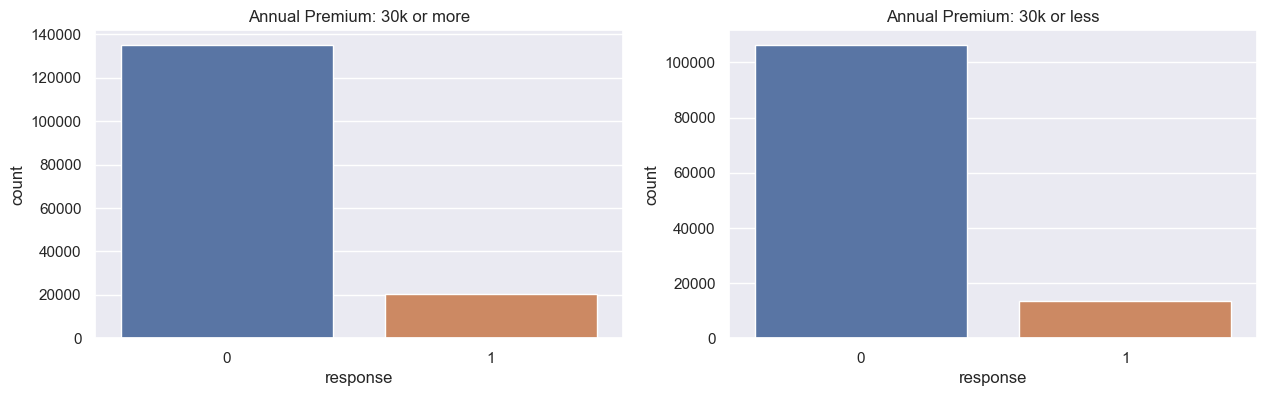

In [18]:
# 4. The interest on purchase the vehicle insurance is greater for customers that spend less than 30k for annual premium.
aux5 = df4_eda[df4_eda['annual_premium'] > 30000][['id','response']]
aux6 = df4_eda[df4_eda['annual_premium'] <= 30000][['id','response']]

fix, axs = plt.subplots(ncols = 2, figsize = (15,4))
sns.countplot(x = aux5['response'], ax=axs[0]).set_title('Annual Premium: 30k or more')
sns.countplot(x = aux6['response'], ax=axs[1]).set_title('Annual Premium: 30k or less')

In [19]:
aux16 = aux5[['response','id']].groupby('response').count().reset_index()
aux16['percentage'] = round( aux16['id'] / aux5.shape[0] * 100 )
aux16

,response,id,percentage
0,0,135186,87.0
1,1,20426,13.0


In [20]:
aux17 = aux6[['response','id']].groupby('response').count().reset_index()
aux17['percentage'] = round( aux17['id'] / aux6.shape[0] * 100 )
aux17

,response,id,percentage
0,0,106352,89.0
1,1,13386,11.0


In [21]:
# 6. The interest on purchase the vehicle insurance is greater for customers that have driver license.
aux9 = pd.crosstab(df4_eda['driving_license'], df4_eda['response'])
aux9['percentage'] = round(aux9[1]/(aux9[0]+aux9[1])*100)
aux9

response,0,1,percentage
driving_license,,,
0,553,28,5.0
1,240985,33784,12.0


In [22]:
# 7. The interest on purchase the vehicle insurance is greater for customers that have new cars.
aux10 = pd.crosstab(df4_eda['vehicle_age'], df4_eda['response'])
aux10['percentage'] = round(aux10[1]/(aux10[0]+aux10[1])*100)
aux10

response,0,1,percentage
vehicle_age,,,
1,113706,5236,4.0
2,119676,25172,17.0
3,8156,3404,29.0


In [23]:
# 8. The interest on purchase the vehicle insurance is greater for customers that have new cars and have damaged their vehicles.
aux11 = df4_eda[(df4_eda['vehicle_damage'] == 1 )]
aux12 = pd.crosstab(aux11['vehicle_age'], aux11['response'])
aux12['percentage'] = round(aux12[1]/(aux12[0]+aux12[1])*100)
aux12

response,0,1,percentage
vehicle_age,,,
1,29875,4966,14.0
2,68017,24740,27.0
3,8145,3404,29.0


In [24]:
# 10. The interest on purchase the vehicle insurance is lower for customers that are already insured.
aux15 = pd.crosstab(df4_eda['previously_insured'], df4_eda['response'])
aux15['percentage'] = round(aux15[1]/(aux15[0]+aux15[1])*100)
aux15

response,0,1,percentage
previously_insured,,,
0,115780,33693,23.0
1,125758,119,0.0


**Hypothesis Validation**

1. The interest on purchase the vehicle insurance is greater for customers that damaged their vehicle before and doesn't have insurance.
    **False, of the customers that damaged their car and doesn't have insurance, only 25% show interest in acquire vehicle insurance.**

2. The interest on purchase the vehicle insurance is greater for woman than men.
    **False, only 10% of women show interest in acquire vehicle insurance, whereas 13% of the men show interest on acquire vehicle insurance.**

3. The interest on purchase vehicle insurance is greater for vintage customers ( 7 months or more ).
    **False, the period that customers are on the company doensn't show influency on interest in buying vehicle insurance.**

4. The interest on purchase the vehicle insurance is greater for young customers.(Between 18 and 30 years old.)
    **False, customers that spend more than 30k yearly show greter interest on purchase vehicle insurance.**

5. The interest on purchase the vehicle insurance is greater for young customers.(Between 18 and 30 years old.)
    **False, adults and elderlies show greater interest on buying vehicle insurance.**

6. The interest on purchase the vehicle insurance is greater for customers that have driver license.
    **True, arround 12% of customers that hold a driving license show interest in buying the vehicle insurance.**

7. The interest on purchase the vehicle insurance is greater for customers that have new cars.
    **False, the interest is greater for customers that own an old car.**

8. The interest on purchase the vehicle insurance is greater for customers that have new cars and have damaged their vehicles.
    **False, of the customers who damaged their car, the ones that own a old car show greater interest in buying the vehicle insurance (29%), followed by customers that own used cars (27%).**

9. The interest on purchase the vehicle insurance is greater for elderly women.
    **False, adult women show greater interest in buying the vehicle insurance.**

10. The interest on purchase the vehicle insurance is lower for customers that are already insured.
    **True, less than 1% of customers already insured show interest on purchase the vehicle insurance.**


### 4.3 - MULTIVARIATE ANALYSIS

<AxesSubplot: >

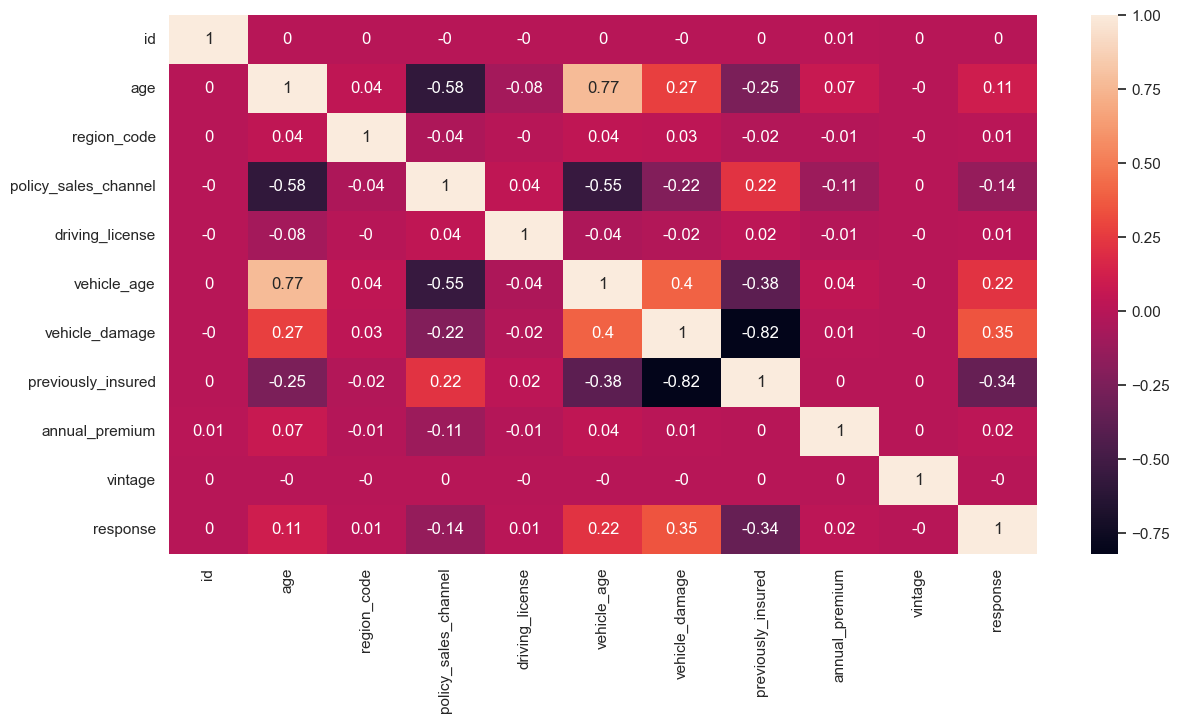

In [25]:
correlation = df4_eda.corr().round(2)
plt.figure(figsize = (14,7))
sns.heatmap(correlation, annot = True)

## 5 - DATA PREPARATION

In [26]:
df5 = df4.copy()

In [27]:
df5.dtypes

id                       int64
gender                  object
age                      int64
region_code              int64
policy_sales_channel     int64
driving_license          int64
vehicle_age              int64
vehicle_damage           int64
previously_insured       int64
annual_premium           int64
vintage                  int64
dtype: object

### 5.1 - STANDARDIZATION

In [28]:
ss_ap = pp.StandardScaler()
df5['annual_premium'] = ss_ap.fit_transform( df5[['annual_premium']].values )

#pickle.dump(ss_ap, open('C:/Users/perot/Documents/ds_repos/projects/Health_Insurance_Cross_Sell/src/features/annual_premium_scaler.pkl', 'wb'))

### 5.2 - REESCALING

In [29]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()
mms_dl = pp.MinMaxScaler()

# Age
df5['age'] = mms_age.fit_transform( df5[['age']].values )
#pickle.dump(mms_age, open('C:/Users/perot/Documents/ds_repos/projects/Health_Insurance_Cross_Sell/src/features/age_scaler.pkl', 'wb'))

# Vintage
df5['vintage'] = mms_vintage.fit_transform( df5[['vintage']].values )
#pickle.dump(mms_vintage, open('C:/Users/perot/Documents/ds_repos/projects/Health_Insurance_Cross_Sell/src/features/vintage_scaler.pkl', 'wb'))

# Driving License
df5['driving_license'] = mms_dl.fit_transform( df5[['driving_license']].values )

### 5.3 - ENCODER

In [30]:
# gender
fe_gender = df5.groupby('gender').size() / len(df5)
df5.loc[:, 'gender'] = df5['gender'].map( fe_gender )
#pickle.dump(target_encode_gender, open('C:/Users/perot/Documents/ds_repos/projects/Health_Insurance_Cross_Sell/src/features/target_encode_gender_scaler.pkl', 'wb'))

# region_code - Frequency Encoding / Target Encoding / Weighted Targed Encoding
fe_region_code = df5.groupby( 'region_code').size() / len( df5 )
df5.loc[:, 'region_code'] = df5['region_code'].map( fe_region_code )
#pickle.dump(fe_region_code, open('C:/Users/perot/Documents/ds_repos/projects/Health_Insurance_Cross_Sell/src/features/frequency_encode_region_code_scaler.pkl', 'wb'))

# policy_sales_channel - Frequency Encoding / Target Encoding
fe_policy_sales_channel = df5.groupby( 'policy_sales_channel' ).size() / len( df5 ) 
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( fe_policy_sales_channel )
#pickle.dump(fe_policy_sales_channel, open('C:/Users/perot/Documents/ds_repos/projects/Health_Insurance_Cross_Sell/src/features/frequency_encode_policy_sales_scaler.pkl', 'wb'))

### 5.4 - VALIDATION PREPARATION

#### 5.5.1 -  Apply Feature Engineering on validation dataset

In [31]:
# Fitting vehicle_age column
x_valid['vehicle_age'] = x_valid['vehicle_age'].apply(lambda x: 1 if (x == '< 1 Year') else 2 if (x == '1-2 Year') else 3)

# Fitting vehicle_damage column
x_valid['vehicle_damage'] = x_valid['vehicle_damage'].apply(lambda x: 1 if (x == 'Yes') else 0)

#### 5.5.2 -  Apply Data Transformation on validation dataset

In [32]:
# STANDARDIZATION

# annual premium
x_valid.loc[:, 'annual_premium'] = ss_ap.transform( x_valid[['annual_premium']].values )



# REESCALING

# age
x_valid.loc[:, 'age'] = mms_age.transform( x_valid[['age']].values )

# vintage
x_valid.loc[:, 'vintage'] = mms_vintage.transform( x_valid[['vintage']].values )



# ENCODER

# policy sales channel
x_valid.loc[:, 'policy_sales_channel'] = x_valid['policy_sales_channel'].map( fe_policy_sales_channel )

# region code
x_valid.loc[:, 'region_code'] = x_valid.loc[:, 'region_code'].map( fe_region_code )

# gender
x_valid.loc[:, 'gender'] = x_valid.loc[:, 'gender'].map( fe_gender )

# FILL NAN VALUES
x_valid = x_valid.fillna(0)

## 6 - FEATURE SELECTION

In [33]:
df6 = df5.copy()

In [34]:
# model definition
forest = en.ExtraTreesClassifier( n_estimators =250, random_state=0, n_jobs=-1 )

# data preparation
df6_n = df6.drop( ['id'], axis=1 )
y_train_n  = y_train.values
forest.fit( df6_n, y_train_n )

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking:
                feature  importance
0               vintage    0.278930
0        annual_premium    0.247041
0                   age    0.161848
0           region_code    0.099515
0        vehicle_damage    0.073736
0  policy_sales_channel    0.060914
0    previously_insured    0.054774
0           vehicle_age    0.017286
0                gender    0.005454
0       driving_license    0.000503


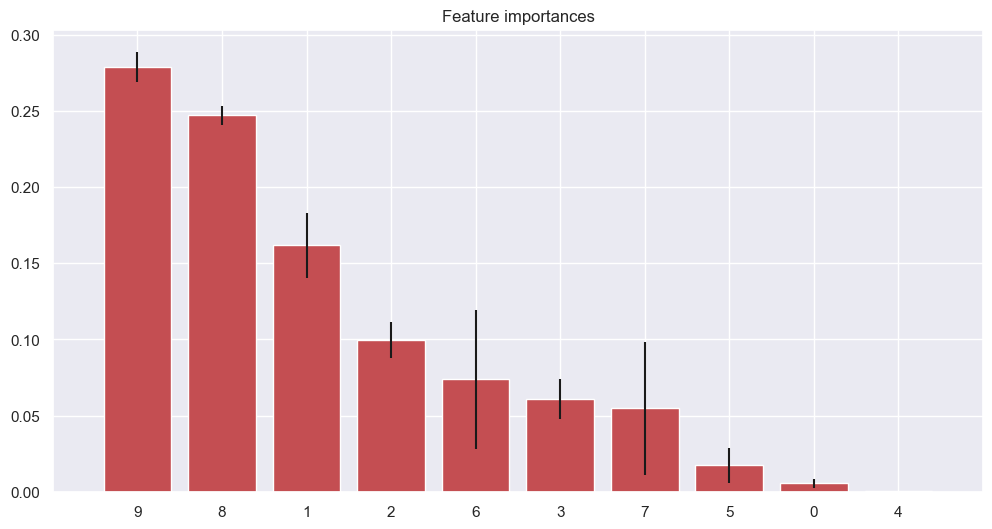

In [35]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0 )
indices = np.argsort(importances)[::-1]

# Print the feature ranking 
print("Feature ranking:")
df = pd.DataFrame()
for i,j in zip( df6_n, forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df,aux], axis = 0 )
    
print( df.sort_values( 'importance', ascending=False ) )

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(df6_n.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(df6_n.shape[1]), indices)
plt.xlim([-1, df6_n.shape[1]])
plt.show()

In [36]:
cols_selected = ['vintage', 'annual_premium','age','region_code','vehicle_damage','policy_sales_channel','previously_insured','vehicle_age']

x_training = df6[ cols_selected ]
x_validation = x_valid[ cols_selected ]
y_validation = y_valid

## 7 - ML MODELS TRAINING

#### MACHILE LEARNING TRAINING

In [37]:
# Treinamento do modelo com os dados de treino
xgb_model = XGBClassifier(scale_pos_weight=7.2)
xgb_model.fit( x_training, y_train )

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [38]:
# Recall sobre dados de Treinamento
yhat_xgb_train = xgb_model.predict( x_training )
recall_train = mt.recall_score(y_train, yhat_xgb_train)
print("Recall Over Training {}".format(recall_train))

# Recall sobre dados de Validacao
yhat_xgb_valid = xgb_model.predict( x_validation )
recall_valid = mt.recall_score(y_valid, yhat_xgb_valid)
print("Recall Over Valid {}".format(recall_valid))

# Recall sobre dados de Teste
yhat_xgb_test = xgb_model.predict( x_test )
recall_test = mt.recall_score(y_test, yhat_xgb_test)
print("Recall Over Test {}".format(recall_test))

Recall Over Training 0.9451082455932804
Recall Over Valid 0.9008826508464767


ValueError: Feature shape mismatch, expected: 8, got 11

#### 7.1.1 - XGB Model

In [39]:
# Parameter "scale_pos_weight" definition

from collections import Counter

# ESTIMATE SCALE_POS_WEIGHT
counter = Counter(y_train)
estimate = counter[0]/counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 7.144


In [40]:
# model definition
xgb_model = XGBClassifier(scale_pos_weight=estimate)

# model training
xgb_model.fit( x_training, y_train )

# model prediction - Check if the model perform well
yhat_xgb = xgb_model.predict_proba( x_validation )

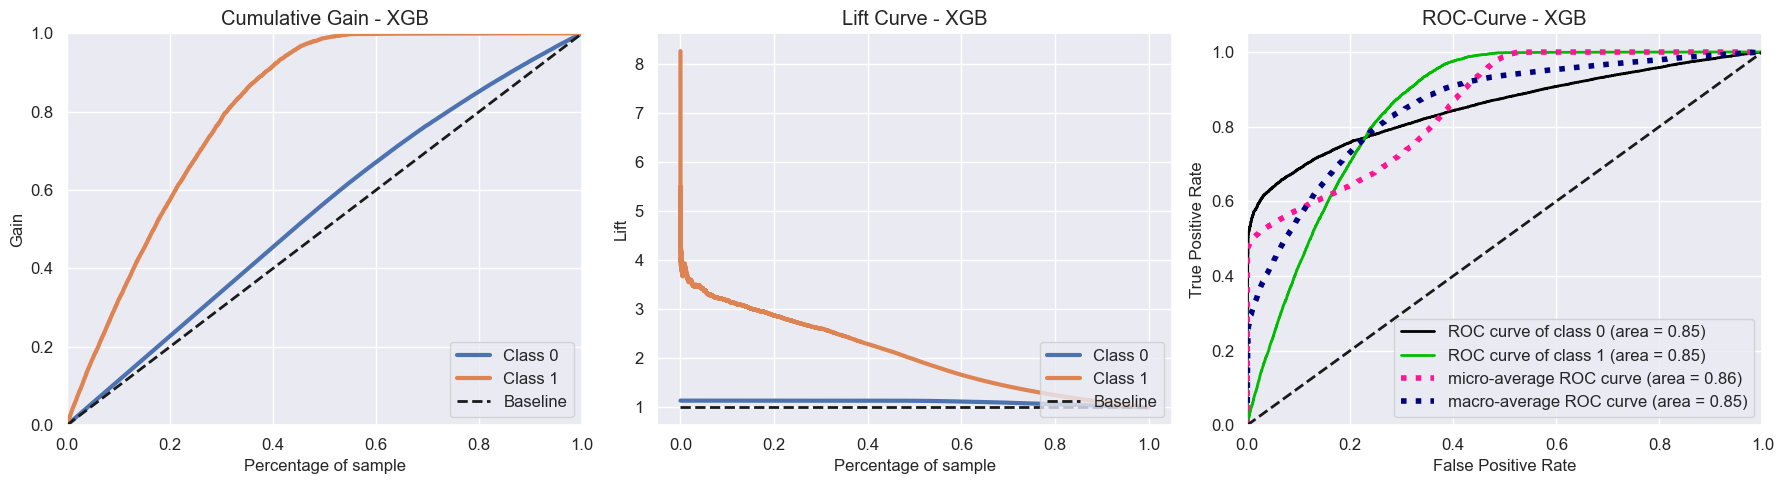

In [41]:
fig, axs = plt.subplots(ncols= 3, figsize = (18,5))

# cumulative gain - Metric for sorting problem
skplt.metrics.plot_cumulative_gain(y_validation, yhat_xgb, ax=axs[0],title='Cumulative Gain - XGB');

# Lift Curve
skplt.metrics.plot_lift_curve(y_validation, yhat_xgb,ax=axs[1],title='Lift Curve - XGB');

# Roc Curve
skplt.metrics.plot_roc(y_validation, yhat_xgb, ax=axs[2], title='ROC-Curve - XGB');

plt.tight_layout()

#### 7.1.2 - KNN

In [42]:
# model definition
knn_model = nh.KNeighborsClassifier( n_neighbors=8 )

# model training
knn_model.fit( x_training, y_train )

# model prediction - The generalization POWER
yhat_knn = knn_model.predict_proba( x_validation )

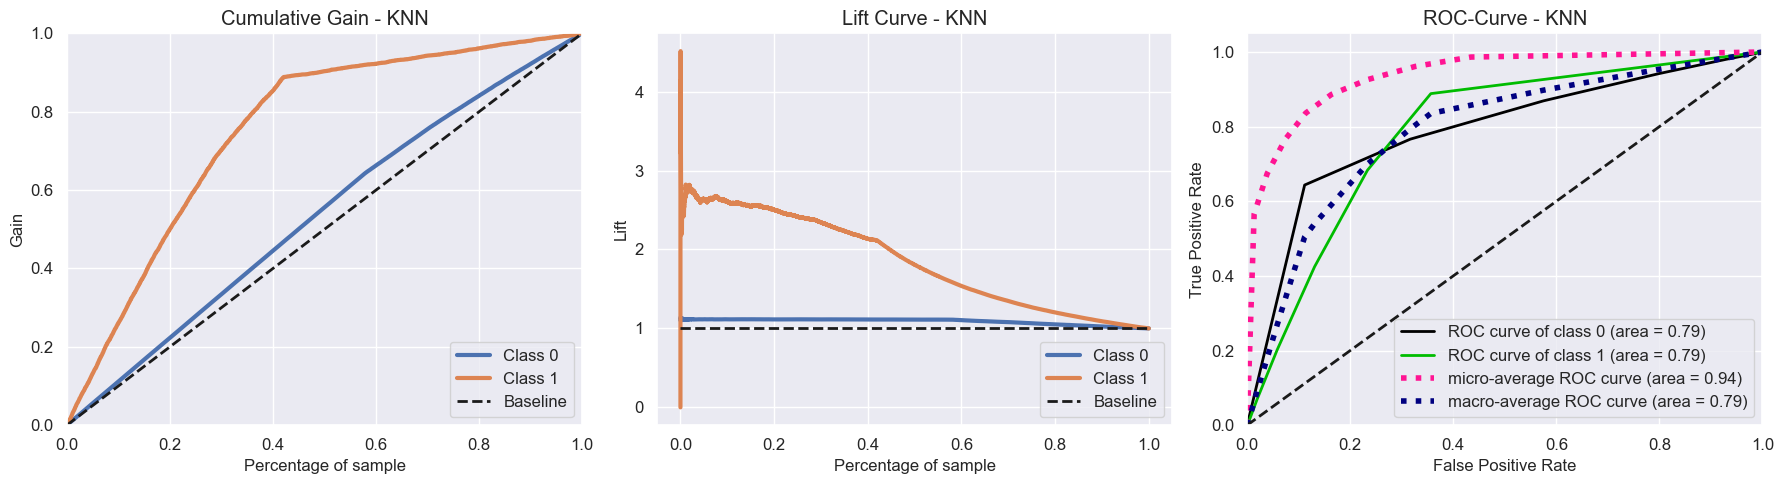

In [43]:
fig, axs = plt.subplots(ncols= 3, figsize = (18,5))

# cumulative gain - Metric for sorting problem
skplt.metrics.plot_cumulative_gain(y_validation, yhat_knn, ax=axs[0],title='Cumulative Gain - KNN');

# Lift Curve
skplt.metrics.plot_lift_curve(y_validation, yhat_knn, ax=axs[1],title='Lift Curve - KNN');

# Roc Curve
skplt.metrics.plot_roc(y_validation, yhat_knn, ax=axs[2], title='ROC-Curve - KNN');

plt.tight_layout()

#### 7.1.3 - Light gradient Boostin Machine Classifier Model

In [44]:
# Model Definition
lgbm_model = lgbm.LGBMClassifier( learning_rate=0.09, max_depth=-5, random_state=42 )

# Model training
model_lgbm = lgbm_model.fit( x_training, y_train )

# Model Prediction
yhat_lgbm = model_lgbm.predict_proba( x_validation )

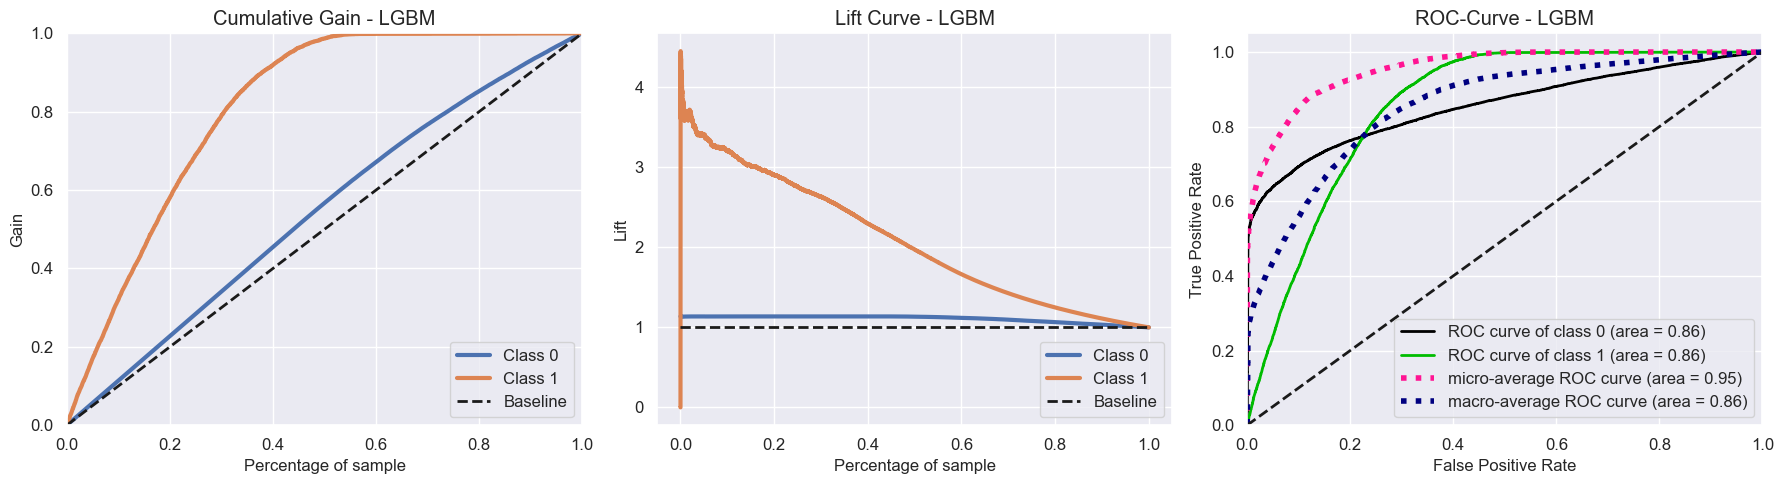

In [45]:
fig, axs = plt.subplots(ncols= 3, figsize = (18,5))

# cumulative gain - Metric for sorting problem
skplt.metrics.plot_cumulative_gain(y_validation, yhat_lgbm, ax=axs[0],title='Cumulative Gain - LGBM');

# Lift Curve
skplt.metrics.plot_lift_curve(y_validation, yhat_lgbm,ax=axs[1],title='Lift Curve - LGBM');

# Roc Curve
skplt.metrics.plot_roc(y_validation, yhat_lgbm, ax=axs[2], title='ROC-Curve - LGBM');

plt.tight_layout()

## 8 - MODEL PERFORMANCE

### 8.1 - XGB MODEL PERFORMANCE

In [46]:
# Copy Data
perf_valid= x_validation.copy()
perf_valid['response'] = y_validation.copy()

# Propensity score
perf_valid['score'] = yhat_xgb[:,1].tolist()

# sorted clients by score
perf_valid = perf_valid.sort_values( 'score', ascending=False )

# Compute precision at K
precision_atK = precision_at_k(perf_valid, k=20000 )

# Compute precision at K
recall_atK = recall_at_k(perf_valid, k=20000 )

xgb_performance = ml_performance('XGB Model', precision_atK, recall_atK )
xgb_performance

,Model Name,Precision_at_K,Recall_at_K
0,XGB Model,0.296985,0.859499


### 8.2 - KNN MODEL PERFORMANCE

In [47]:
# Copy Data
perf_valid = x_validation.copy()
perf_valid['response'] = y_validation.copy()

# Propensity score
perf_valid['score'] = yhat_knn[:,1].tolist()

# sorted clients by score
perf_valid = perf_valid.sort_values( 'score', ascending=False )

# Compute precision at K
precision_atK = precision_at_k(perf_valid, k=20000 )

# Compute precision at K
recall_atK = recall_at_k(perf_valid, k=20000 )

KNN_performance = ml_performance('KNN_Model', precision_atK, recall_atK )
KNN_performance

,Model Name,Precision_at_K,Recall_at_K
0,KNN_Model,0.269887,0.781074


### 8.3 - LGBM MODEL PERFORMANCE

In [48]:
# Copy Data
perf_valid = x_validation.copy()
perf_valid['response'] = y_validation.copy()

# Propensity score
perf_valid['score'] = yhat_lgbm[:,1].tolist()

# sorted clients by score
perf_valid = perf_valid.sort_values( 'score', ascending=False )

# Compute precision at K
precision_atK = precision_at_k(perf_valid, k=20000 )

# Compute precision at K
recall_atK = recall_at_k(perf_valid, k=20000 )

lgbm_performance = ml_performance('LGBM Model', precision_atK, recall_atK )
lgbm_performance

,Model Name,Precision_at_K,Recall_at_K
0,LGBM Model,0.299535,0.866879


### 8.3 - PERFORMANCE FOR ALL MODELS

In [49]:
model_performance = pd.concat( [xgb_performance, KNN_performance, lgbm_performance] )
model_performance.sort_values('Precision_at_K', ascending= False)

,Model Name,Precision_at_K,Recall_at_K
0,LGBM Model,0.299535,0.866879
0,XGB Model,0.296985,0.859499
0,KNN_Model,0.269887,0.781074


## 9 - HYPERPARAMETER FINE TUNING

### 9.1 - LGBM Fine Tunning

In [50]:
import random

In [51]:
# Union of training dataset to select best parameters for XGB Model
x_train_lgbm = pd.concat([x_training, y_train], axis=1)

In [52]:
param = {
'n_estimators':[100,350,550,850,1000],
'learning_rate': [0.01, 0.03, 0.05, 0.08, 0.1],
'max_depth':[5, 9, 13, 17, 20]}

MAX_EVAL = 5

In [53]:
final_result = pd.DataFrame()

for i in range( MAX_EVAL ):
# choose values for parameters randomly
    hp = { k: random.sample(v, 1)[0] for k, v in param.items() }
    print( hp )
    
#    # model
    lgbm_model = lgbm.LGBMClassifier( scale_pos_weight=7.2,
                                      n_estimators =hp['n_estimators'],
                                      learning_rate=hp['learning_rate'],
                                      max_depth=hp['max_depth'],
                                      objective='binary',
                                      metric='binary_logloss')
    # performance
    result = cross_validation(2, 'lgbm classifier', lgbm_model, x_train_lgbm, 20000)
    final_result = pd.concat( [final_result, result] )

final_result

{'n_estimators': 100, 'learning_rate': 0.05, 'max_depth': 5}
{'n_estimators': 850, 'learning_rate': 0.08, 'max_depth': 9}
{'n_estimators': 100, 'learning_rate': 0.08, 'max_depth': 5}
{'n_estimators': 1000, 'learning_rate': 0.1, 'max_depth': 13}
{'n_estimators': 850, 'learning_rate': 0.08, 'max_depth': 20}


,lgbm classifier
precision_at_k,0.3703
std_precision,+/-0.0012
recall_at_k,0.4381
std_recall,+/- 0.0014
precision_at_k,0.3627
std_precision,+/-0.0013
recall_at_k,0.4291
std_recall,+/- 0.0015
precision_at_k,0.3727
std_precision,+/-0.0005


### 9.3 - XGB Fine Tunning

In [54]:
import random

In [55]:
# Union of training dataset to select best parameters for XGB Model
x_train_xgb = pd.concat([x_training, y_train], axis=1)

In [56]:
param = {
     'n_estimators': [100,350,550,850,1000], 
     'eta': [0.01, 0.03],
     'max_depth': [5, 9, 13, 17, 20],
     'subsample': [0.1, 0.5, 0.7],
     'colsample_bytree': [0.3, 0.7, 0.9],
     'min_child_weight':[3, 8, 15] }

MAX_EVAL = 5

In [57]:
final_result = pd.DataFrame()

for i in range( MAX_EVAL ):
# choose values for parameters randomly
    hp = { k: random.sample(v, 1)[0] for k, v in param.items() }
    print( hp )
    
#    # model
    model_xgb = XGBClassifier( scale_pos_weight=7.2,
                               colsample_bytree =hp['colsample_bytree'],
                               subsample = hp['subsample'],
                               objective='binary:logistic',
                               eval_metric='logloss', 
                               n_estimators=hp['n_estimators'], 
                               max_depth=hp['max_depth'],
                               min_child_weight = hp['min_child_weight'],
                               eta=hp['eta'])
    # performance
    result = cross_validation(2, 'xgb classifier', model_xgb, x_train_xgb, 20000)
    final_result = pd.concat( [final_result, result] )

final_result

{'n_estimators': 350, 'eta': 0.01, 'max_depth': 17, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 3}
{'n_estimators': 550, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 3}
{'n_estimators': 550, 'eta': 0.03, 'max_depth': 20, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 3}
{'n_estimators': 850, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 8}
{'n_estimators': 550, 'eta': 0.03, 'max_depth': 13, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 8}


,xgb classifier
precision_at_k,0.3589
std_precision,+/-0.0006
recall_at_k,0.4246
std_recall,+/- 0.0007
precision_at_k,0.3702
std_precision,+/-0.0003
recall_at_k,0.438
std_recall,+/- 0.0003
precision_at_k,0.3401
std_precision,+/-0.0017


###  9.3.2 - Last model training with all datas

#### 9.3.2.1 - Data preparation applied on validation and test datasets.

In [58]:
x_test = data_preparation( x_test )

#### 9.3.2.2 - Union of training and validation data.

In [59]:
x_train_treino = pd.concat([ x_training, x_validation ] )
y_train_treino = pd.concat([ y_train, y_validation ] )

#### 9.3.2.3 - Generalization capacity of LGBM Model

In [60]:
params_lgbm = { 'scale_pos_weight':7.2,
                'n_estimators':350,
                'learning_rate':0.1,
                'max_depth':5,
                'objective':'binary',
                'metric':'binary_logloss'}

In [61]:
# Model Definition
lgbm_model = lgbm.LGBMClassifier(**params_lgbm )

# Model Training
model_lgbm = lgbm_model.fit( x_train_treino, y_train_treino )

In [62]:
# Model Prediction
yhat_lgbm = model_lgbm.predict_proba( x_test )

In [63]:
# Copy Data
df_test = x_test.copy()
df_test['response'] = y_test.copy()

# Propensity score
df_test['score'] = yhat_lgbm[:,1].tolist()

# sorted clients by score
df_test = df_test.sort_values( 'score', ascending=False )

# Compute precision at K
precision_atK = precision_at_k(df_test, k=20000 )

# Compute precision at K
recall_atK = recall_at_k(df_test, k=20000 )

lgbm_performance_cv = ml_performance('LGBM Model', precision_atK, recall_atK )
lgbm_performance_cv

,Model Name,Precision_at_K,Recall_at_K
0,LGBM Model,0.281536,0.940538


In [64]:
yhat_lgbm_curve = yhat_lgbm[:,1]

In [65]:
precision, recall, thresholds = precision_recall_curve(y_test, yhat_lgbm_curve)

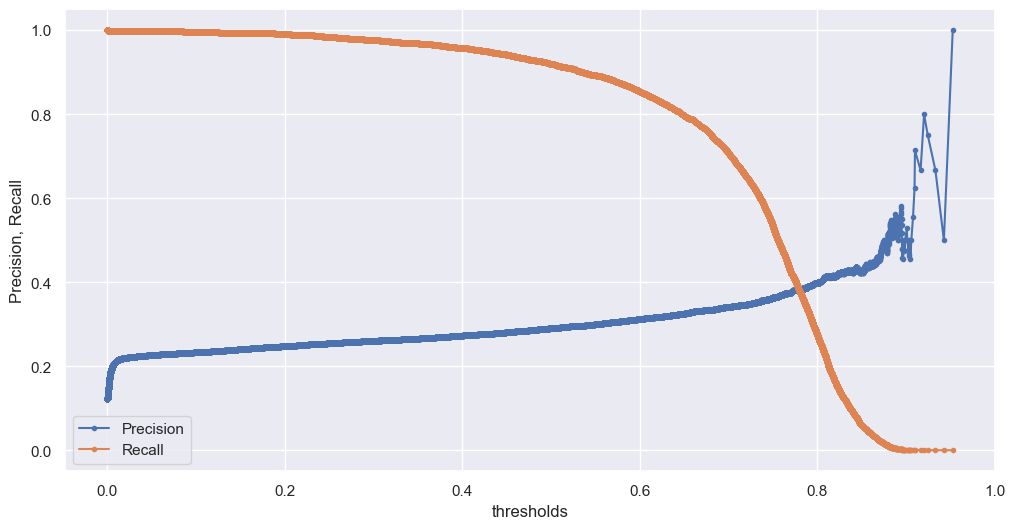

In [66]:
# plot curves
plt.plot(thresholds, precision[:-1], marker='.', label='Precision')
plt.plot(thresholds, recall[:-1], marker='.', label='Recall')
plt.xlabel('thresholds')
plt.ylabel('Precision, Recall')
plt.legend()
plt.show()

#### 9.3.2.4 - Generalization capacity of XGB Model

In [67]:
params_xgb = {'scale_pos_weight':7.2,
              'colsample_bytree':0.9, 
              'subsample':0.5, 
              'objective':'binary:logistic',
              'eval_metric':'logloss', 
              'n_estimators':1000, 
              'max_depth':13, 
              'min_child_weight':15,
              'eta':0.01}

In [68]:
# XGB Model

# model definition
model_xgb_cv = XGBClassifier(** params_xgb)

# model training
model_xgb_cv.fit( x_training, y_train )

# model prediction - The generalization POWER
yhat_xgb_cv = model_xgb_cv.predict_proba( x_test )

In [69]:
# Copy Data
df_test = x_test.copy()
df_test['response'] = y_test.copy()

# Propensity score
df_test['score'] = yhat_xgb_cv[:,1].tolist()

# sorted clients by score
df_test = df_test.sort_values( 'score', ascending=False )

# Compute precision at K
precision_atK = precision_at_k(df_test, k=20000 )

# Compute precision at K
recall_atK = recall_at_k(df_test, k=20000 )

xgb_performance_cv = ml_performance('XGB Model', precision_atK, recall_atK )
xgb_performance_cv

,Model Name,Precision_at_K,Recall_at_K
0,XGB Model,0.280336,0.936529


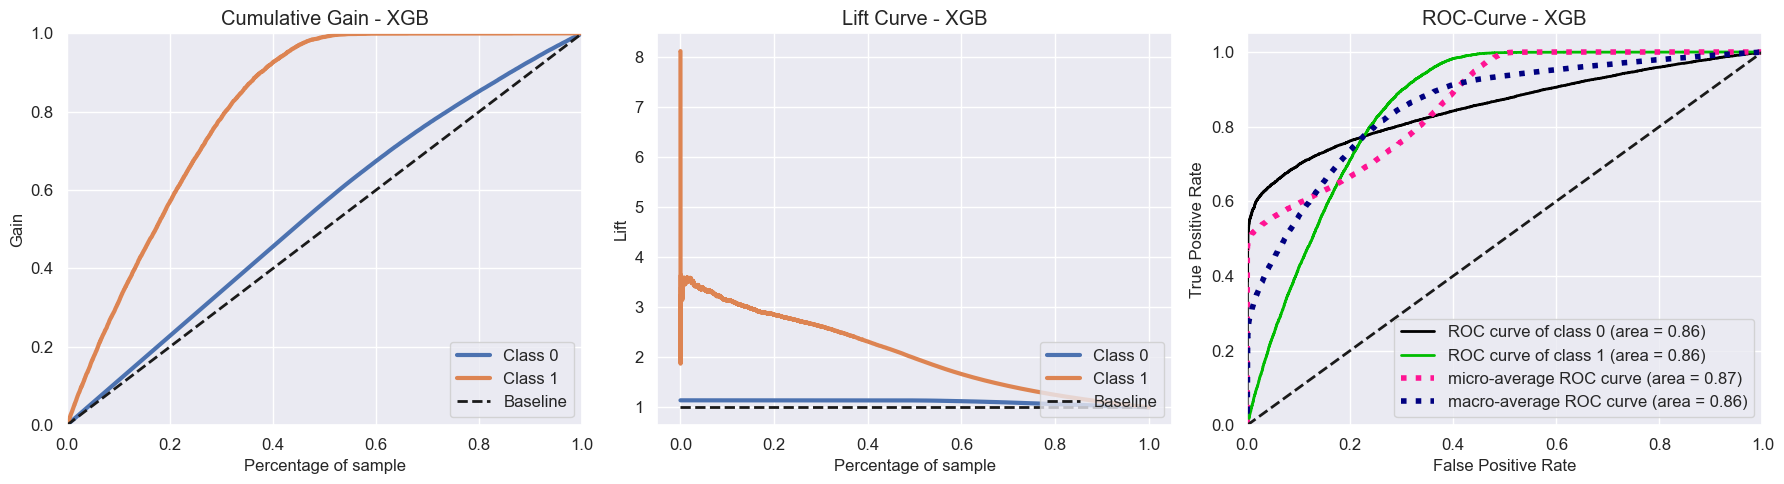

In [70]:
fig, axs = plt.subplots(ncols= 3, figsize = (18,5))

# cumulative gain - Metric for sorting problem
skplt.metrics.plot_cumulative_gain(y_test, yhat_xgb_cv, ax=axs[0],title='Cumulative Gain - XGB');

# Lift Curve
skplt.metrics.plot_lift_curve(y_test, yhat_xgb_cv,ax=axs[1],title='Lift Curve - XGB');

# Roc Curve
skplt.metrics.plot_roc(y_test, yhat_xgb_cv, ax=axs[2], title='ROC-Curve - XGB');

plt.tight_layout()

In [71]:
yhat_xgb_curve = yhat_xgb_cv[:,1]

In [72]:
precision, recall, thresholds = precision_recall_curve( y_test, yhat_xgb_curve)

In [73]:
x_test.shape

(48592, 8)

In [74]:
thresholds

array([5.0434074e-04, 5.2557280e-04, 5.3724361e-04, ..., 9.2177480e-01,
       9.2271829e-01, 9.3802810e-01], dtype=float32)

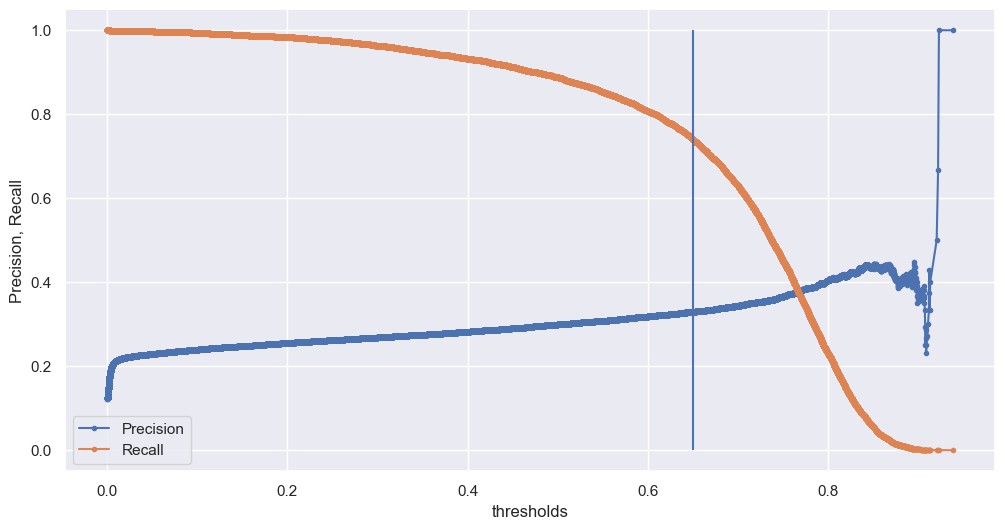

In [83]:
# plot curves
plt.plot(thresholds, precision[:-1], marker='.', label='Precision')
plt.plot(thresholds, recall[:-1], marker='.', label='Recall')
plt.xlabel('thresholds')
plt.ylabel('Precision, Recall')
plt.legend()
plt.show()

### 9.1 - Cross Validation

In [76]:
df_cc = pd.concat([x_train_treino, y_train_treino], axis=1)

In [77]:
# Dictioary with models instantiated
models = {'XGB Model': model_xgb_cv,
          'LGBM Model': model_lgbm }

# Cross-validated models performance
model_performance = pd.DataFrame()

for key in models.keys():
    performance_cv = cross_validation(5, key, models[key], df_cc, 20000)
    model_performance = pd.concat([model_performance, performance_cv], axis=1)

model_performance.T

,precision_at_k,std_precision,recall_at_k,std_recall
XGB Model,0.3175,+/-0.0015,0.7798,+/- 0.0037
LGBM Model,0.3197,+/-0.0015,0.7851,+/- 0.0037


#### 9.3.2.5 - Last training with all datas before deploying to production

In [78]:
# Union of training, validation and test datasets
df_last = df_raw.copy()

# Split response variable into a new dataset
x_last_training = df_last.drop( 'response', axis=1 )
y_last_training = df_last['response'].copy()

# Applying data transformation
x_last_training = data_preparation( x_last_training )

In [79]:
# XGB Model Last Training

# model definition
model_xgb_lv= XGBClassifier( **params_xgb )

# model training
model_xgb_lv.fit( x_last_training, y_last_training )

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eta=0.01, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=13,
              max_leaves=None, min_child_weight=15, missing=nan,
              monotone_constraints=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [80]:
pickle.dump(model_xgb_lv, open('C:/Users/perot/Documents/ds_repos/projects/Health_Insurance_Cross_Sell/src/models/xgb_model.pkl', 'wb'))

## 10 - DEPLOYING MODEL TO PRODUCTION

### 10.1 - HEALTHINSURANCE CLASS

In [ ]:
import pickle
import inflection
import numpy  as np
import pandas as pd

class HealthInsurance:
    
    def __init__( self ):
        self.home_path                                = ''
        self.frequency_encode_policy_sales_scaler     = pickle.load( open( self.home_path + 'src/features/frequency_encode_policy_sales_scaler.pkl', 'rb') )
        self.frequency_encode_region_code_scaler      = pickle.load( open( self.home_path + 'src/features/frequency_encode_region_code_scaler.pkl', 'rb') )
        self.target_encode_gender_scaler              = pickle.load( open( self.home_path + 'src/features/target_encode_gender_scaler.pkl', 'rb') )
        self.age_scaler                               = pickle.load( open( self.home_path + 'src/features/age_scaler.pkl', 'rb') )
        self.vintage_scaler                           = pickle.load( open( self.home_path + 'src/features/vintage_scaler.pkl', 'rb') )
        self.annual_premium_scaler                    = pickle.load( open( self.home_path + 'src/features/annual_premium_scaler.pkl', 'rb') )

    
    def data_cleaning( self, df5 ):
 
        ## rename Columns
        cols_old = ['id', 'Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']

        snakecase = lambda x: inflection.underscore( x )
        cols_new = list( map( snakecase, cols_old ) )
        
        # rename
        df5.columns = cols_new
        
        return( df5 )

    def feature_engineering( self, df5 ):
        
        # Changing data types
        df5['region_code'] = df5['region_code'].astype(object)
        df5['policy_sales_channel'] = df5['policy_sales_channel'].astype(object)
        
        # Fitting vehicle_age column
        df5['vehicle_age'] = df5['vehicle_age'].apply(lambda x: 1 if (x == '< 1 Year') else 2 if (x == '1-2 Year') else 3)

        # Fitting vehicle_damage column
        df5['vehicle_damage'] = df5['vehicle_damage'].apply(lambda x: 1 if (x == 'Yes') else 0)
              
        return( df5 )
    
    def data_preparation( self, df5 ):
              
        # STANDARDIZATION

        # annual premium
        df5['annual_premium'] = self.annual_premium_scaler.transform( df5[['annual_premium']].values )


        # REESCALING

        # age
        df5['age'] = self.age_scaler.transform( df5[['age']].values )

        # vintage
        df5['vintage'] = self.vintage_scaler.transform( df5[['vintage']].values )



        # ENCODER

        # policy sales channel
        df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( self.frequency_encode_policy_sales_scaler )

        # region code
        df5.loc[:, 'region_code'] = df5['region_code'].map( self.frequency_encode_region_code_scaler )

        # gender
        df5.loc[:, 'gender'] = df5['gender'].map( self.target_encode_gender_scaler )

        # FILL NAN VALUES
        df5 = df5.fillna(0)
        
        # Feature Selection
        cols_selected = ['vintage', 'annual_premium','age','region_code','vehicle_damage','policy_sales_channel','previously_insured','vehicle_age']
        
        return df5[cols_selected]
    

    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict_proba( test_data )
        
        # join pred into the original data
        original_data['score'] = pred[:, 1].tolist()
        
        return original_data.to_json( orient='records', date_format='iso' )

### 10.2 - API HANDLER

In [ ]:
import pickle
import pandas as pd
import os
from flask                           import Flask, request, Response
from healthinsurance.healthinsurance import HealthInsurance

# logading model
model = pickle.load( open( 'src/models/xgb_m odel.pkl', 'rb' ) )
                          
# initialize API
app = Flask( __name__ )

@app.route( '/healthinsurance/predict', methods=['POST'] )
def health_insurance_predict():
    test_json = request.get_json()
    
    if test_json: #there is data
               
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
    
        else:
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() ) # multiple examples
            
        # Instantiate Rossmann Class
        pipeline = HealthInsurance()

        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
              
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )

        # Data Preparation
        df3 = pipeline.data_preparation( df2 )
                              
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
        
    else:
        return Response( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    app.run('0.0.0.0')

#    port = os.environ.get('PORT', 5000)
#    app.run( host='0.0.0.0', port=port )

### 10.3 - API Tester

In [ ]:
import requests
import pandas as pd

In [ ]:
# Load Datasets
df_test = pd.read_csv('C:/Users/perot/Documents/ds_repos/projects/Health_Insurance_Cross_Sell/data/raw/test.csv')

In [ ]:
#df_test = df_test.sample(10)

In [ ]:
df_test.head()

In [ ]:
# convert dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [ ]:
# API Call
#url = 'https://healthinsurance-api.onrender.com/healthinsurance/predict'
url = 'http://127.0.0.1:5000/healthinsurance/predict'
header = {'Content-type': 'application/json' }

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

In [ ]:
d2 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [ ]:
d2.to_csv('scores.csv')